## Lab 9: Predicting Forest Cover Type with SVMs

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [63]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load the dataset
df = pd.read_csv("/courses/EDS232/Data/covtype_sample.csv")

### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [3]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2955.599500,154.450000,14.114700,268.097600,45.755300,2319.360300,212.19660,223.113500,142.243800,1960.040200,...,0.091200,0.082900,0.00250,0.00250,0.000200,0.000500,0.026800,0.024500,0.013600,2.036600
std,281.786673,111.851861,7.499705,211.899673,58.034207,1548.558651,26.98846,19.871067,37.799752,1320.535941,...,0.287908,0.275745,0.04994,0.04994,0.014141,0.022356,0.161507,0.154603,0.115829,1.383782
min,1860.000000,0.000000,0.000000,0.000000,-164.000000,0.000000,68.00000,71.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2804.750000,58.000000,9.000000,95.000000,7.000000,1091.750000,198.00000,213.000000,119.000000,1006.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2995.000000,126.000000,13.000000,218.000000,29.000000,1977.000000,218.00000,226.000000,142.000000,1699.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3159.000000,258.000000,18.000000,384.000000,68.000000,3279.000000,231.00000,237.000000,168.000000,2524.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3846.000000,359.000000,65.000000,1243.000000,427.000000,7078.000000,254.00000,254.000000,246.000000,7111.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [64]:
#df[np.abs(stats.zscore(df)) > 3].count()

In [5]:
y = df["Cover_Type"]
x = df.drop(columns = "Cover_Type")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 808)

x_train_scaled = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x.columns)
x_test_scaled = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x.columns)

In [6]:
x_train_scaled.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
count,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,...,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03,7.000000e+03
mean,2.938602e-16,-8.323501e-17,5.176811e-17,-9.846092e-17,5.227564e-17,4.060244e-18,5.113370e-16,-2.004746e-16,5.303694e-17,-3.755726e-17,...,-5.379824e-17,-1.218073e-17,5.430577e-17,-2.537653e-17,-1.015061e-17,1.015061e-17,1.015061e-17,2.030122e-17,-4.669281e-17,-2.030122e-17
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,...,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-3.857776e+00,-1.375326e+00,-1.890051e+00,-1.262248e+00,-3.575672e+00,-1.491430e+00,-5.369187e+00,-7.656482e+00,-3.752051e+00,-1.470719e+00,...,-2.220764e-01,-3.136619e-01,-3.000052e-01,-5.741555e-02,-5.216966e-02,-1.195314e-02,-1.690550e-02,-1.661275e-01,-1.610642e-01,-1.179194e-01
25%,-5.220209e-01,-8.650462e-01,-6.850030e-01,-8.155038e-01,-6.798985e-01,-7.954536e-01,-5.307356e-01,-5.085529e-01,-6.121363e-01,-7.242204e-01,...,-2.220764e-01,-3.136619e-01,-3.000052e-01,-5.741555e-02,-5.216966e-02,-1.195314e-02,-1.690550e-02,-1.661275e-01,-1.610642e-01,-1.179194e-01
50%,1.338463e-01,-2.473397e-01,-1.494260e-01,-2.370880e-01,-2.966343e-01,-2.261939e-01,2.136415e-01,1.458350e-01,-5.262090e-03,-1.948581e-01,...,-2.220764e-01,-3.136619e-01,-3.000052e-01,-5.741555e-02,-5.216966e-02,-1.195314e-02,-1.690550e-02,-1.661275e-01,-1.610642e-01,-1.179194e-01
75%,7.227163e-01,9.254075e-01,6.539396e-01,5.435382e-01,3.762073e-01,6.177257e-01,6.974867e-01,6.995479e-01,6.807697e-01,4.280973e-01,...,-2.220764e-01,-3.136619e-01,-3.000052e-01,-5.741555e-02,-5.216966e-02,-1.195314e-02,-1.690550e-02,-1.661275e-01,-1.610642e-01,-1.179194e-01
max,3.145194e+00,1.838539e+00,6.813076e+00,4.564234e+00,6.491400e+00,3.061362e+00,1.553520e+00,1.555286e+00,2.738865e+00,3.837131e+00,...,4.502954e+00,3.188146e+00,3.333276e+00,1.741688e+01,1.916823e+01,8.366003e+01,5.915235e+01,6.019472e+00,6.208705e+00,8.480369e+00


In [7]:
q = x.quantile(0.9999999)
#test_scaled.drop(test_scaled[test_scaled.any() < np.abs(q)])

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [10]:
parameters = {
    "C": (0.1, 1, 10, 100), 
    "kernel": ("linear", "rbf"), 
    "gamma": ("scale", "auto")
}

strat_kf = StratifiedKFold()

In [8]:
time_before_svc = time.time()

best_svc = GridSearchCV(
    SVC(random_state = 808), 
    parameters,
    cv = strat_kf,
    n_jobs = -1
).fit(x_train_scaled, y_train_scaled)

time_after_svc = time.time()

total_time_svc = time_after_svc - time_before_svc

KeyboardInterrupt: 

### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [40]:
parameters_rf = {
    'max_features': ('sqrt', 6, None), 
    'n_estimators': (50, 100, 200), 
    'min_samples_split': (2, 5, 10)
}

time_before_rf = time.time()

best_rf = GridSearchCV(
    RandomForestClassifier(random_state = 808), 
    parameters_rf,
    cv = strat_kf,
    n_jobs = -1
).fit(x_train_scaled, y_train)

time_after_rf = time.time()

total_time_rf = time_after_rf - time_before_rf

In [42]:
best_rf.best_params_

{'max_features': 6, 'min_samples_split': 2, 'n_estimators': 200}

### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


In [ ]:
# 1 -- Spruce/Fir
# 2 -- Lodgepole Pine
# 3 -- Ponderosa Pine
# 4 -- Cottonwood/Willow
# 5 -- Aspen
# 6 -- Douglas-fir
# 7 -- Krummholz

In [ ]:
pred_svc = best_svc.predict(x_test_scaled)

cm_svc = confusion_matrix(y_test, pred_svc)

#Plot confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cm_svc, 
            fmt = 'd', # specify whole integer format for value labels
            cmap = sns.color_palette("Greens", as_cmap=True), 
            annot = True, 
            xticklabels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz'], 
            yticklabels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz'])
plt.title('Confusion Matrix for Support Vector Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

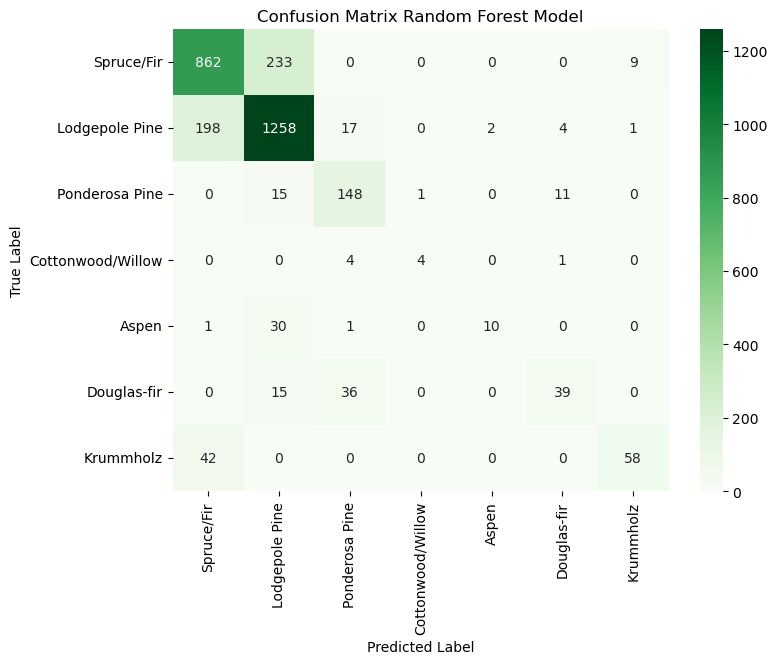

In [55]:
pred_rf = best_rf.predict(x_test_scaled)

cm_rf = confusion_matrix(y_test, pred_rf)

#Plot confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cm_rf, 
            fmt = 'd', # specify whole integer format for value labels
            cmap = sns.color_palette("Greens", as_cmap=True), 
            annot = True, 
            xticklabels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz'], 
            yticklabels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz'])
plt.title('Confusion Matrix Random Forest Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

In [61]:
print(f"_________Support vector metrics__________\n\t\tAccuracy: {accuracy_score(y_test, pred_svc)}\n\t\tComputation time: {total_time_svc}")
print(f"_________Random Forest metrics__________\n\t Accuracy: {accuracy_score(y_test, pred_rf)}\n\t Computation time: {total_time_rf}")

_________Random Forest metrics__________
	 Accuracy: 0.793
	 Computation time: 18.866316318511963


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


*your answer here*